* ref : https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings(action='ignore')

#### 공통함수

In [2]:
def myscore(y_test,pred,proba, pr_curve=0, auc_curve=0):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test, proba[:,-1])
    print("Accuracy:{:.6f}  precision:{:.6f}, recall:{:.6f}, f1:{:.6f}, auc:{:.6f}".format(accuracy, precision, recall, f1, auc))

    mtx = confusion_matrix(y_test, pred)
    print(mtx)
    
    if pr_curve==1:
        mycurve(y_test, proba)
    if auc_curve==1:
        mycurve_auc(y_test, proba)
        

In [3]:
def mysplit(df, test_size=0.3) :
    df_X = df.iloc[:, :-1]
    df_y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size, random_state=0, stratify=df_y)   #------Stratified 기반 분할
    return  X_train, X_test, y_train, y_test

In [4]:
from sklearn.metrics import precision_recall_curve
def mycurve(y_test, proba):  
    precision, recall, thresholds = precision_recall_curve(y_test, proba[ : , -1])
    print(len(precision), len(recall), len(thresholds))  #66 66 65
    plt.plot(thresholds, precision[:len(thresholds)], label="precision")
    plt.plot(thresholds, recall[:len(thresholds)], label="recall")
    plt.xlabel("thresholds")
    plt.ylabel("score")
    plt.grid()
    plt.legend()
    plt.show()
    

In [5]:
def mycurve_auc(y_test, proba):  
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,-1])
    print(len(fpr), len(tpr), len(thresholds))  #66 66 65
    plt.plot(fpr, tpr, label="roc")
    plt.plot([0,1], [0,1], label="th:0.5")
    plt.xlabel("FPR (1-TNR(specificity)")      #FP
    plt.ylabel("TPR (recall,sensitivity)") #TP
    plt.title(f"auc : {roc_auc_score(y_test, proba[:,-1]):.4f}")
    plt.grid()
    plt.legend()
    plt.show()

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width=600 height=400>

In [6]:
def myoutlier(df=None, column=None, weight=1.5):
    df = df[df['Class']==1][column]
    p25 = np.percentile(df.values, 25)
    p75 = np.percentile(df.values, 75)
    IQR = (p75 - p25) * weight
    low_limit  = p25 - IQR
    high_limit = p75 + IQR
    outlier_idx = df[(df < low_limit) | (df > high_limit)].index.values.tolist()
    return outlier_idx

### 1. data collection

In [7]:
df = pd.read_csv('creditcard.csv')

### 2. EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### target 불균형 확인

In [10]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

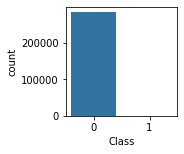

In [11]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.countplot('Class', data=df, ax=ax)

#### 카테고리성 피쳐 확인

In [31]:
oh_numeric_feature = []
for col in df.columns:
    if df[col].nunique() <= 40:
        print(col, df[col].unique())
        oh_numeric_feature.append(col)

Class [0 1]


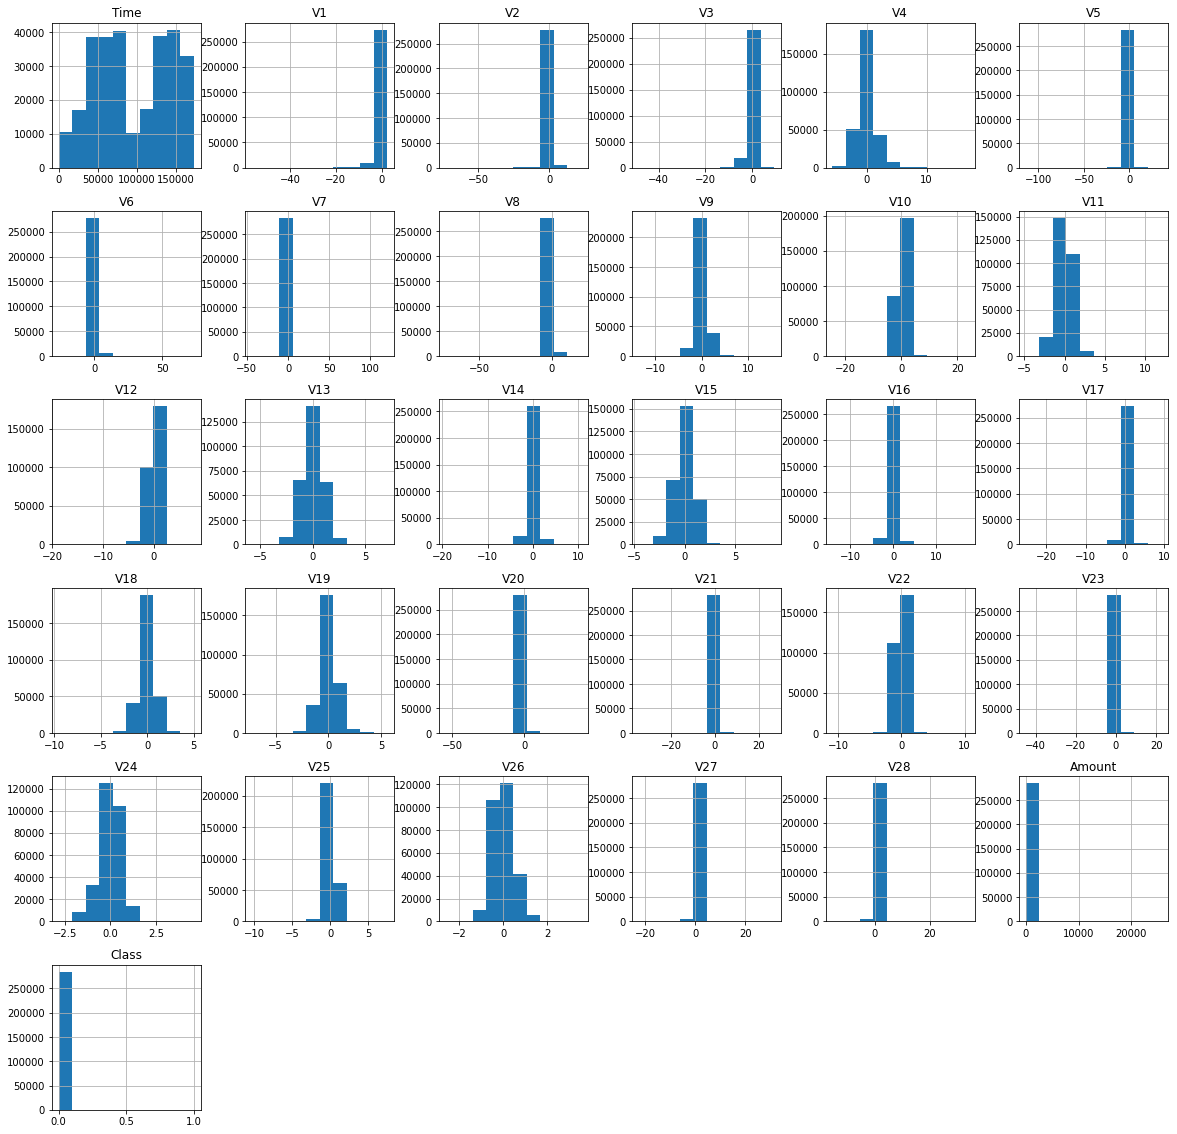

In [13]:
df.hist(figsize=(20,20))
plt.show()

#### 0데이터 확인

In [14]:
nan_dict = {"CNT":df.isin([0]).sum(),
            "RATE": df.isin([0]).sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

           CNT       RATE
Class   284315  99.827251
Amount    1825   0.640785
Time         2   0.000702


#### missing value

In [15]:
# df.isna().sum()>0
nan_dict = {"CNT":df.isna().sum(),
            "RATE": df.isna().sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

Empty DataFrame
Columns: [CNT, RATE]
Index: []


#### 상관분석

<AxesSubplot:>

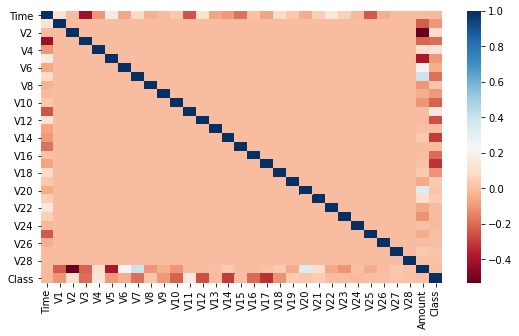

In [16]:
plt.figure(figsize=(9, 5))
sns.heatmap(df.corr(), cmap='RdBu')  #under_df.corr()

<pre>
* positive :  V11, V4, V2, V21
    V11       0.154876
    V4        0.133447
    V2        0.091289
    V21       0.040413
* Negative : V17, V14, V12, V10, V16
    V7       -0.187257
    V3       -0.192961
    V16      -0.196539
    V10      -0.216883
    V12      -0.260593
    V14      -0.302544
    V17      -0.326481
</pre>

In [32]:
df.corrwith(df["Class"]).sort_values(ascending=False)

Class        1.000000
V11          0.154876
V4           0.133447
V2           0.091289
V21          0.040413
V19          0.034783
V20          0.020090
V8           0.019875
V27          0.017580
V28          0.009536
T_Amount     0.005632
V26          0.004455
V25          0.003308
V22          0.000805
V23         -0.002685
V15         -0.004223
V13         -0.004570
V24         -0.007221
T_Amount2   -0.008326
V6          -0.043643
V5          -0.094974
V9          -0.097733
V1          -0.101347
V18         -0.111485
V7          -0.187257
V3          -0.192961
V16         -0.196539
V10         -0.216883
V12         -0.260593
V14         -0.302544
V17         -0.326481
dtype: float64

#### Outlier 확인

* Boxplots

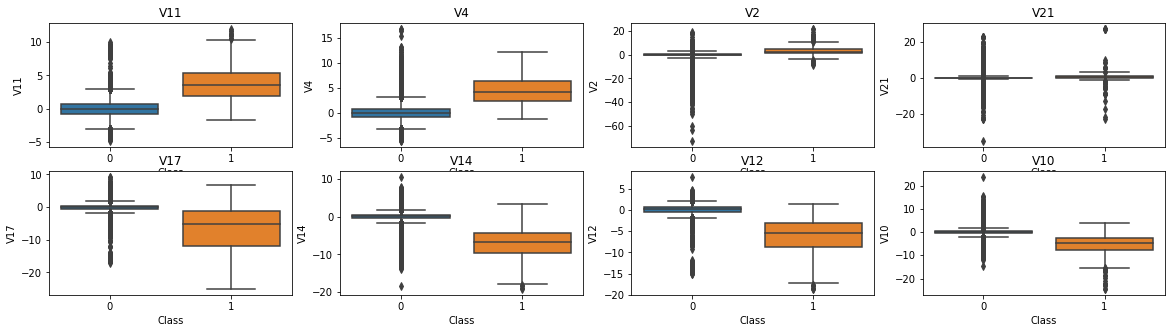

In [18]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[0][3])

# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][0])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][1])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][2])
# sns.boxplot(x="Class", y=col, data=df, ax=axes[1][3])

for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.boxplot(x="Class", y=feature, data=df, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)

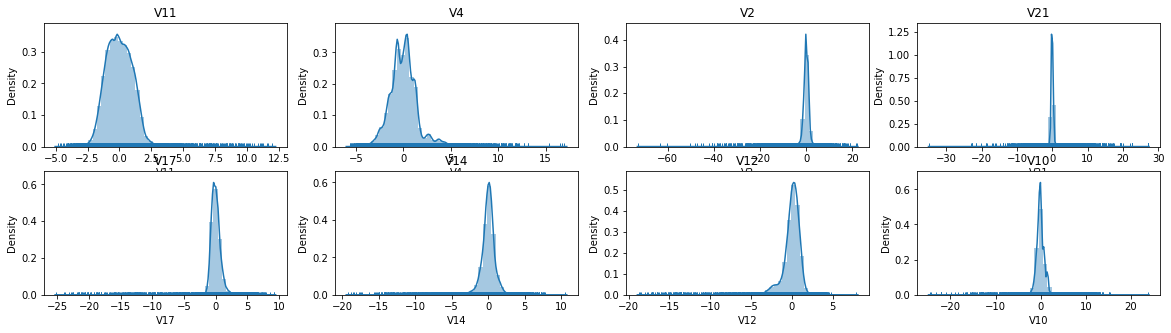

In [19]:
positive=['V11', 'V4', 'V2', 'V21']
negative=['V17', 'V14', 'V12', 'V10'] #, 'V16']
pos_neg = positive + negative
# print(cols)
f, axes = plt.subplots(2,4, figsize=(20,5))
for i, feature in enumerate(pos_neg):
    cols = i%4
    rows = i//4     
    sns.distplot(df[feature], kde=True, rug=True, ax=axes[rows][cols])
    axes[rows][cols].set_title(feature)
    

* IQR 이용

In [20]:
# col_idx = myoutlier(df=df, column='V11', weight=1.5)
for col in pos_neg:
    res = myoutlier(df=df, column=col, weight=1.5)
    print(col,  len(res), "\t\t", res)

V11 10 		 [8296, 8335, 8615, 9035, 9179, 9252, 9487, 9509, 10568, 10801]
V4 0 		 []
V2 46 		 [14211, 15166, 15204, 15225, 15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 33276, 82400, 83297, 102441, 102442, 102443, 102444, 102445, 102446, 151006, 151007, 151008, 151009, 151462, 151519, 152223, 152295, 153823, 153835, 154234, 154371, 154587, 154684, 176049, 249607, 258403, 274382]
V21 49 		 [10801, 10891, 10897, 11343, 11710, 11841, 11880, 12070, 12108, 12261, 12369, 42958, 43204, 44223, 44270, 77682, 102441, 102442, 102443, 102444, 102445, 102446, 144754, 149145, 149600, 151006, 151007, 151008, 151009, 151011, 151462, 151519, 151730, 151807, 152019, 152223, 152295, 153823, 153835, 153885, 154234, 154371, 154587, 154684, 167184, 167305, 189878, 231978, 272521]
V17 0 		 []
V14 4 		 [8296, 8615, 9035, 9252]
V12 6 		 [8296, 8615, 150601, 150644, 150647, 150654]
V10 19 		 [44223, 44270, 150679, 150680, 150697, 151006, 151007, 151008, 

#### Time Amount 확인

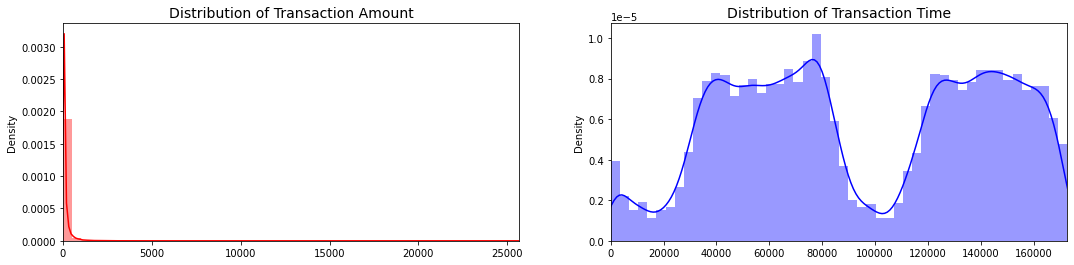

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

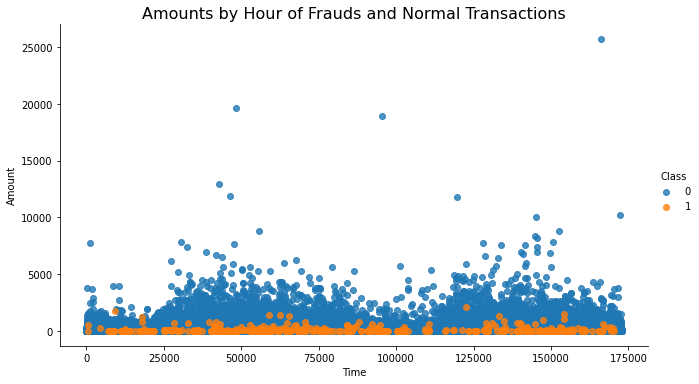

In [22]:
ax = sns.lmplot(y="Amount", x="Time", fit_reg=False, aspect=1.8, data=df, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)
plt.show()

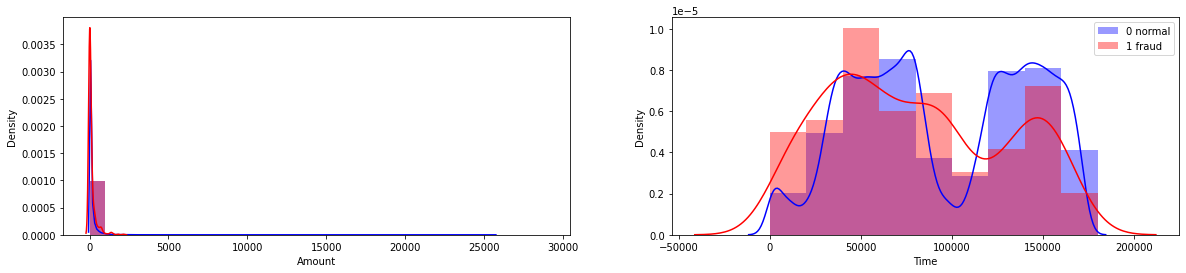

In [23]:
fig, axes = plt.subplots(figsize=(20, 4), ncols=2)
# plt.xticks(range(0, 30000, 1000), rotation=60)

bins = np.arange(0, 30000, 1000)
sns.distplot(df[df['Class']==0]['Amount'] , ax=axes[0], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Amount'] , ax=axes[0], bins=bins, color='r', label='1 fraud')

bins = np.arange(0, 200000, 20000)
sns.distplot(df[df['Class']==0]['Time'] , ax=axes[1], bins=bins, color='b', label='0 normal')
sns.distplot(df[df['Class']==1]['Time'] , ax=axes[1], bins=bins, color='r', label='1 fraud')

plt.legend()
plt.show()

# 전처리 & 가공

In [24]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
# X_train['T_Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
# X_test['T_Amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))       #------------fit안함..주의주의
sacler_val = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.insert(0, 'T_Amount', sacler_val)

sacler_val = np.log1p(df['Amount'])
df.insert(0, 'T_Amount2', sacler_val)

df.drop(['Time','Amount', 'T_Amount'], axis=1, inplace=True)


In [25]:
df.head()

,T_Amount2,T_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,5.014760,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.305626,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.939276,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,4.824306,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,4.262539,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# 분석 모델

### 우선 점수부터 보자

In [34]:
X_train, X_test, y_train, y_test = mysplit(df)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(199364, 30) (85443, 30) 199364 85443


In [39]:
y_test.value_counts()

0    85295
1      148
Name: Class, dtype: int64

In [40]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [44]:
lr = LogisticRegression(random_state = 36)
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)
myscore(y_test, pred_lr, proba_lr)

Accuracy:0.999157  precision:0.865385, recall:0.608108, f1:0.714286, auc:0.971793
[[85281    14]
 [   58    90]]


Accuracy:0.999286  precision:0.817518, recall:0.756757, f1:0.785965, auc:0.878232
[[85270    25]
 [   36   112]]
3 3 2


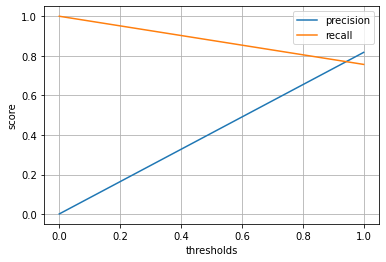

3 3 3


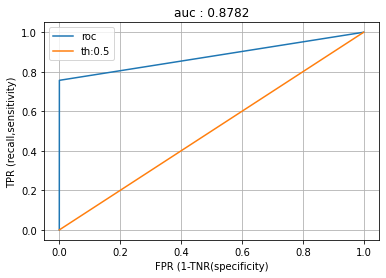

In [42]:
dt = DecisionTreeClassifier(random_state = 36)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
proba_dt = dt.predict_proba(X_test)
myscore(y_test, pred_dt, proba_dt, pr_curve=1, auc_curve=1)

# 평가검증  
* 평가 auc  f1

In [27]:
# np.log1p('') #Amount

In [28]:
# MinMax StarndScaler ---?

In [29]:
# Time : 일반/정상 거래...

## 검증 
* GridSearchCV cv=10회 
* 교차검증